###Installing dependencies

In [3]:
!pip install gym
!pip install gym stable-baselines3 torch numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 50.8 MB/s eta 0:00:00


##Imports

In [4]:
from collections import namedtuple,deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import math
import random
import matplotlib
import matplotlib.pyplot as plt

from itertools import count

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

##Modifying the BlackJack Environment

In [21]:
import os
from typing import Optional

import numpy as np

import gym
from gym.error import DependencyNotInstalled

import gymnasium
from gymnasium import spaces


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

class BlackjackBettingEnv(gymnasium.Env):
    """
    Blackjack is a card game where the goal is to beat the dealer by obtaining cards
    that sum to closer to 21 (without going over 21) than the dealers cards.

    ### Description
    Card Values:

    - Face cards (Jack, Queen, King) have a point value of 10.
    - Aces can either count as 11 (called a 'usable ace') or 1.
    - Numerical cards (2-9) have a value equal to their number.

    This game is played with an infinite deck (or with replacement).
    The game starts with the dealer having one face up and one face down card,
    while the player has two face up cards.

    The player can request additional cards (hit, action=1) until they decide to stop (stick, action=0)
    or exceed 21 (bust, immediate loss).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust, the player wins.
    If neither the player nor the dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.

    ### Action Space
    There are two actions: stick (0), and hit (1).

    ### Observation Space
    The observation consists of a 3-tuple containing: the player's current sum,
    the value of the dealer's one showing card (1-10 where 1 is ace),
    and whether the player holds a usable ace (0 or 1).

    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (http://incompleteideas.net/book/the-book-2nd.html).

    ### Rewards
    - win game: +1
    - lose game: -1
    - draw game: 0
    - win game with natural blackjack:

        +1.5 (if <a href="#nat">natural</a> is True)

        +1 (if <a href="#nat">natural</a> is False)

    ### Arguments

    ```
    gym.make('Blackjack-v1', natural=False, sab=False)
    ```

    <a id="nat">`natural=False`</a>: Whether to give an additional reward for
    starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

    <a id="sab">`sab=False`</a>: Whether to follow the exact rules outlined in the book by
    Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.
    If the player achieves a natural blackjack and the dealer does not, the player
    will win (i.e. get a reward of +1). The reverse rule does not apply.
    If both the player and the dealer get a natural, it will be a draw (i.e. reward 0).

    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, starting_balance=100, num_rounds=10, render_mode: Optional[str] = None, natural=False, sab=False):
        self.starting_balance = starting_balance
        self.balance = starting_balance
        self.current_bet = 0
        self.action_space = spaces.Discrete(4) # [Stick/Stand, Hit, Bet Low, Bet High]
        self.max_rounds = num_rounds
        self.current_round = 0


        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2), spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32), spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32))
        ) # Current sum, dealer's one showing card, whether player holds a usable ace, player's current amount, current bet (low=0, high=1)

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        self.render_mode = render_mode


    def handle_empty_balance(self):
        terminated = True
        reward = -1.0
        return self._get_obs(), reward, terminated, False, {"info": "Player ran out of money."}

    # Game should terminate after 10 rounds or reaching 0
    def step(self, action):
        assert self.action_space.contains(action)
        reward = 0
        info = {}
        terminated = False
        truncated = False

        """
          if: Agent should choose to bet first, if it doesn't the agent bets all their money
          elif: Agent already placed a bet, its next action should not be to bet again so give it a negative reward.

        """
        if self.current_bet == 0:
          if action not in [2,3]:
            self.current_bet = self.balance
            self.balance -= self.current_bet
            reward += -0.5
        elif self.current_bet > 0 and action in [2,3]:
          reward += -1

        """ACTIONS"""
        if action == 2:
          self.current_bet = 10
          self.balance -= self.current_bet
          if self.balance <= 0:
            return self.handle_empty_balance()
          info = {"info": "Player placed a low bet."}


        elif action == 3:
          self.current_bet = 50
          self.balance -= self.current_bet
          if self.balance <= 0:
            return self.handle_empty_balance()
          info = {"info": "Player placed a high bet."}

            # return self._get_obs(), -1, True, True, {"info": "Game ended early due to improper action. (No bet placed)"} #returns next state, reward, terminated, truncation. extra information
        elif action == 0: # STICK: play out dealers hand and score, Round concludes
          self.current_round += 1

          while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
          reward_bonus = cmp(score(self.player), score(self.dealer))
          if(reward_bonus == 1):
            reward += reward_bonus
            self.balance += self.current_bet*2

          # DOING BASIC BLACKJACK
          # if self.sab and is_natural(self.player) and not is_natural(self.dealer):
          #       # Player automatically wins. Rules consistent with S&B
          #       reward += 1.0
          #       print(f'bet: {self.current_bet}')
          #       self.balance += self.current_bet*2
          # elif (
          #     not self.sab
          #     and self.natural
          #     and is_natural(self.player)
          #     and reward == 1.0
          # ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation


          info = {"info": "Player chose to stick. Round concludes"}

          #reset cards
          self.resetHand()

        elif action == 1: # HIT: add a card to players hand and return
          self.player.append(draw_card(self.np_random))
          if is_bust(self.player): # Player busts, round concludes
              terminated = False
              reward += -1.0
              self.current_round += 1
              self.balance -= self.current_bet
              if self.balance <= 0:
                  return self.handle_empty_balance()

              info = {"info": "Player chose to hit. Player busted. Round concludes."}
              #reset cards
              self.resetHand()
          else:
              terminated = False
              reward += 0.0
              info = {"info": "Player chose to hit. Round continues."}


        """IF ROUND >= MAX_ROUNDS GAME TERMINATES"""
        if self.current_round == self.max_rounds-1:
          terminated = True
          info["info"] += " 10 Rounds Reached."
        return self._get_obs(), reward, terminated, truncated, info

        #IDK WHAT THIS FOR
        # if self.render_mode == "human":
        #     self.render()
        # return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        return (
            sum_hand(self.player),
            self.dealer[0],
            usable_ace(self.player),
            np.array([self.balance], dtype=np.float32),
            np.array([self.current_bet], dtype=np.float32)
        )

    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)


        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        self.current_bet = 0
        self.balance = self.starting_balance
        self.current_round = 0

        _, dealer_card_value, _ , _ , _= self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), {}

    def resetHand(self):
      self.dealer = draw_hand(self.np_random)
      self.player = draw_hand(self.np_random)

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[toy_text]`"
            )

        player_sum, dealer_card_value, usable_ace = self._get_obs()
        screen_width, screen_height = 600, 500
        card_img_height = screen_height // 3
        card_img_width = int(card_img_height * 142 / 197)
        spacing = screen_height // 20

        bg_color = (7, 99, 36)
        white = (255, 255, 255)

        if not hasattr(self, "screen"):
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode((screen_width, screen_height))
            else:
                pygame.font.init()
                self.screen = pygame.Surface((screen_width, screen_height))

        if not hasattr(self, "clock"):
            self.clock = pygame.time.Clock()

        self.screen.fill(bg_color)

        def get_image(path):
            cwd = os.path.dirname(__file__)
            image = pygame.image.load(os.path.join(cwd, path))
            return image

        def get_font(path, size):
            cwd = os.path.dirname(__file__)
            font = pygame.font.Font(os.path.join(cwd, path), size)
            return font

        small_font = get_font(
            os.path.join("font", "Minecraft.ttf"), screen_height // 15
        )
        dealer_text = small_font.render(
            "Dealer: " + str(dealer_card_value), True, white
        )
        dealer_text_rect = self.screen.blit(dealer_text, (spacing, spacing))

        def scale_card_img(card_img):
            return pygame.transform.scale(card_img, (card_img_width, card_img_height))

        dealer_card_img = scale_card_img(
            get_image(
                os.path.join(
                    "img",
                    f"{self.dealer_top_card_suit}{self.dealer_top_card_value_str}.png",
                )
            )
        )
        dealer_card_rect = self.screen.blit(
            dealer_card_img,
            (
                screen_width // 2 - card_img_width - spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        hidden_card_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
        self.screen.blit(
            hidden_card_img,
            (
                screen_width // 2 + spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        player_text = small_font.render("Player", True, white)
        player_text_rect = self.screen.blit(
            player_text, (spacing, dealer_card_rect.bottom + 1.5 * spacing)
        )

        large_font = get_font(os.path.join("font", "Minecraft.ttf"), screen_height // 6)
        player_sum_text = large_font.render(str(player_sum), True, white)
        player_sum_text_rect = self.screen.blit(
            player_sum_text,
            (
                screen_width // 2 - player_sum_text.get_width() // 2,
                player_text_rect.bottom + spacing,
            ),
        )

        if usable_ace:
            usable_ace_text = small_font.render("usable ace", True, white)
            self.screen.blit(
                usable_ace_text,
                (
                    screen_width // 2 - usable_ace_text.get_width() // 2,
                    player_sum_text_rect.bottom + spacing // 2,
                ),
            )
        if self.render_mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else:
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if hasattr(self, "screen"):
            import pygame

            pygame.display.quit()
            pygame.quit()


# Pixel art from Mariia Khmelnytska (https://www.123rf.com/photo_104453049_stock-vector-pixel-art-playing-cards-standart-deck-vector-set.html)

###Check environment

In [22]:
# Create the environment
env = BlackjackBettingEnv()

env.reset()

while True:  # Simulate 5 steps
    action = env.action_space.sample()  # Random action
    state, reward, done, truncate, info = env.step(action)
    print(f"State: {state}, Reward: {reward}, Done: {done}, Info:{info}")
    if done:
        break


    # NEED TO RESET CARDS AFTER ROUND CONCLUDES

State: (16, 10, False, array([90.], dtype=float32), array([10.], dtype=float32)), Reward: 0, Done: False, Info:{'info': 'Player placed a low bet.'}
State: (21, 6, True, array([90.], dtype=float32), array([10.], dtype=float32)), Reward: 0, Done: False, Info:{'info': 'Player chose to stick. Round concludes'}
State: (21, 6, True, array([80.], dtype=float32), array([10.], dtype=float32)), Reward: -1, Done: False, Info:{'info': 'Player placed a low bet.'}
State: (21, 6, True, array([30.], dtype=float32), array([50.], dtype=float32)), Reward: -1, Done: False, Info:{'info': 'Player placed a high bet.'}
State: (19, 5, False, array([130.], dtype=float32), array([50.], dtype=float32)), Reward: 1.0, Done: False, Info:{'info': 'Player chose to stick. Round concludes'}
State: (19, 5, False, array([80.], dtype=float32), array([50.], dtype=float32)), Reward: -1, Done: False, Info:{'info': 'Player placed a high bet.'}
State: (19, 5, False, array([70.], dtype=float32), array([10.], dtype=float32)), Rew

##IGNORE

In [32]:
from stable_baselines3.common.env_checker import check_env

env = BlackjackBettingEnv(starting_balance=100, num_rounds=10)
check_env(env, warn=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 

In [ ]:
env = BlackjackBettingEnv(starting_balance=100, num_rounds=10)
obs, info = env.reset()
print(obs)
print(env.observation_space.contains(obs))  # Should return True

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [ ]:
def preprocess_obs(obs):
    player_sum, dealer_card, usable_ace, balance, bet = obs
    return np.array([
        player_sum, dealer_card, usable_ace, balance[0], bet[0]
    ], dtype=np.float32)


In [ ]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
        )

    def __len__(self):
        return len(self.buffer)


In [ ]:
def train_dqn(env, num_episodes=1000, batch_size=64, gamma=0.99, lr=1e-3, epsilon_decay=0.995):
    # Initialize Q-network, target network, and optimizer
    input_dim = 5  # Flattened observation space dimensions
    output_dim = env.action_space.n
    q_network = QNetwork(input_dim, output_dim)
    target_network = QNetwork(input_dim, output_dim)
    target_network.load_state_dict(q_network.state_dict())  # Sync target network
    optimizer = optim.Adam(q_network.parameters(), lr=lr)

    # Replay buffer and epsilon-greedy parameters
    replay_buffer = ReplayBuffer(capacity=10000)
    epsilon = 1.0
    min_epsilon = 0.01

    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = preprocess_obs(obs)
        total_reward = 0

        done = False
        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = torch.argmax(q_network(torch.tensor(state, dtype=torch.float32))).item()

            # Step in the environment
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = preprocess_obs(next_obs)

            # Store transition in replay buffer
            replay_buffer.add(state, action, reward, next_state, done)

            # Train the Q-network
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                # Convert to tensors
                states = torch.tensor(states, dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.int64)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.tensor(next_states, dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32)

                # Compute Q-values
                q_values = q_network(states)
                q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

                # Compute target Q-values
                with torch.no_grad():
                    next_q_values = target_network(next_states).max(1)[0]
                    target_q_values = rewards + (gamma * next_q_values * (1 - dones))

                # Compute loss
                loss = nn.MSELoss()(q_values, target_q_values)

                # Optimize the Q-network
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            total_reward += reward

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Sync target network periodically
        if episode % 10 == 0:
            target_network.load_state_dict(q_network.state_dict())

        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")


In [ ]:
env = BlackjackBettingEnv(starting_balance=100, num_rounds=10)
train_dqn(env, num_episodes=5)


## DQN


DQN uses a replay memory to store transitions.

In [23]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer(object):
  def __init__(self, capacity):
    self.memory = deque([],maxlen=capacity)

  def push(self, *args):
    """Save a transition"""
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    """Return a random sample of stored transitions"""
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

####DQN Algorithm

Goal: maximize the return(cumulative reward)

A small gamma (discount factor) makes rewards from the future less important than rewards in the near future. So this encourages agents to collect rewards closer in time than wait for far away ones.

The main idea w/ q-learning is that if we take an action in a given state then we can make a policy to maximize rewards.


In [24]:
class DQN(nn.Module):
  def __init__(self, n_observations, n_actions):
    super(DQN, self).__init__()
    self.layer1 = nn.Linear(n_observations, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, n_actions)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    return self.layer3(x)

####DQN Training

In [25]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayBuffer(1000)


steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [26]:
print(env.action_space.sample())

2


Complete


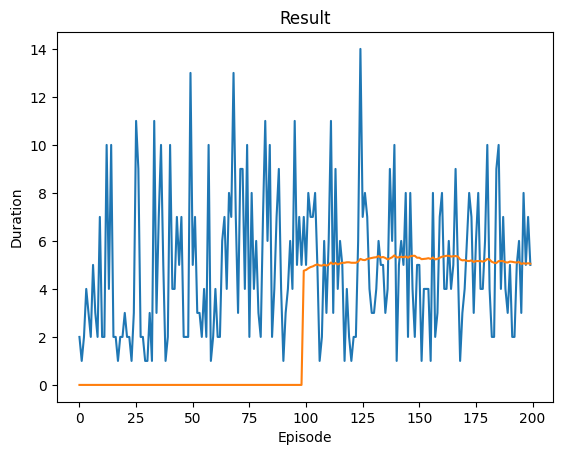

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

num_episodes = 200
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # print(state, info)
    # state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    # for t in count():
    #     action = select_action(state)

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


In [29]:

# Number of evaluation episodes
num_eval_episodes = 100

# Initialize a list to track rewards during evaluation
evaluation_rewards = []

evaluation_money = []

# Evaluate the agent
for eval_episode in range(num_eval_episodes):
    state, info = env.reset()  # Reset the environment at the beginning of each episode
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_reward = 0  # Track total reward for this episode

    # Run the episode
    for t in range(1000):  # You can define a maximum number of steps per episode
        action = select_action(state)  # Select action using epsilon-greedy policy
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward  # Add the reward to the total for this episode

        if terminated or truncated:
            break

        # Update state
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # Store the reward for the current evaluation episode
    evaluation_money.append(env.balance)
    evaluation_rewards.append(episode_reward)

# Print evaluation results
print(f'Average evaluation reward over {num_eval_episodes} episodes: {sum(evaluation_rewards) / num_eval_episodes}')

<ipython-input-29-a7c86959700e>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Average evaluation reward over 100 episodes: 0.705


In [31]:
print(evaluation_money)
print(f'Average evaluation reward over {num_eval_episodes} episodes: {sum(evaluation_money) / num_eval_episodes}')

[-50, 600, 440, -10, 180, -10, 210, 420, -50, 1000, 440, 140, 400, -100, -100, -10, 230, -50, 440, 400, 590, 100, 700, 650, 170, -10, 480, -100, 610, 800, -100, -10, -100, 350, 600, -50, 700, -10, 660, 600, 750, -50, 800, 400, 160, 240, 600, -100, -100, 250, 140, 600, -50, 200, 750, -100, 0, 240, 210, -50, 50, -10, 350, 400, 300, 600, 460, 250, 800, 70, 600, 0, 630, 800, 380, 800, 190, 800, 650, -50, 1200, 540, -10, 100, 450, 250, 350, 380, 200, 1000, 550, 260, 500, 300, 200, -10, 600, 600, -100, 500]
Average evaluation reward over 100 episodes: 319.7


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
